# Hawaii: How COVID-19 Affects Travel

This repository contains code that was used to perform analysis on Hawaii travel data and how COVID-19 affected the tourism in Hawaii. The writeup report can be found [here](https://docs.google.com/document/d/1lFPU9p4GzJJm3OYw7-xgqkegWq8RNLv5AjrgNqfpWRs/edit?usp=sharing)

## Loading data
Here we will load the input datasets

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [2]:
travel_data = pd.read_csv("data/hawaii-data.csv")

In [3]:
confirmed_cases = pd.read_csv("data/RAW_us_confirmed_cases.csv")

## Compute monthly COVID cases
In this section we will compute the monthly COVID cases in Honolulu Hawaii by looking at the accumulative cases for the beginning of each month, and converting that into a series of tuples.

In [4]:
columns = confirmed_cases[confirmed_cases['Admin2'] == "Honolulu"].columns.tolist()

In [5]:
values = confirmed_cases[confirmed_cases['Admin2'] == "Honolulu"].values.tolist()

In [6]:
tuples = [[columns[i], values[0][i]] for i in range(len(columns))]
tuples = [x for x in tuples if len(re.findall("\/1\/", x[0])) > 0 ]

In [7]:
tuples[0].append(0)
for i in range(1, len(tuples)):
    tuples[i].append(tuples[i][1] - tuples[i-1][1])

In [8]:
# tuples will be a series of (date, total cases, monthly cases)
tuples[0].append(0)

## Monthly visitor count trends vs COVID
In this section we will explore the monthly visitor in Hawaii. The first plot we will present the monthly count trends from 2018 to 2021

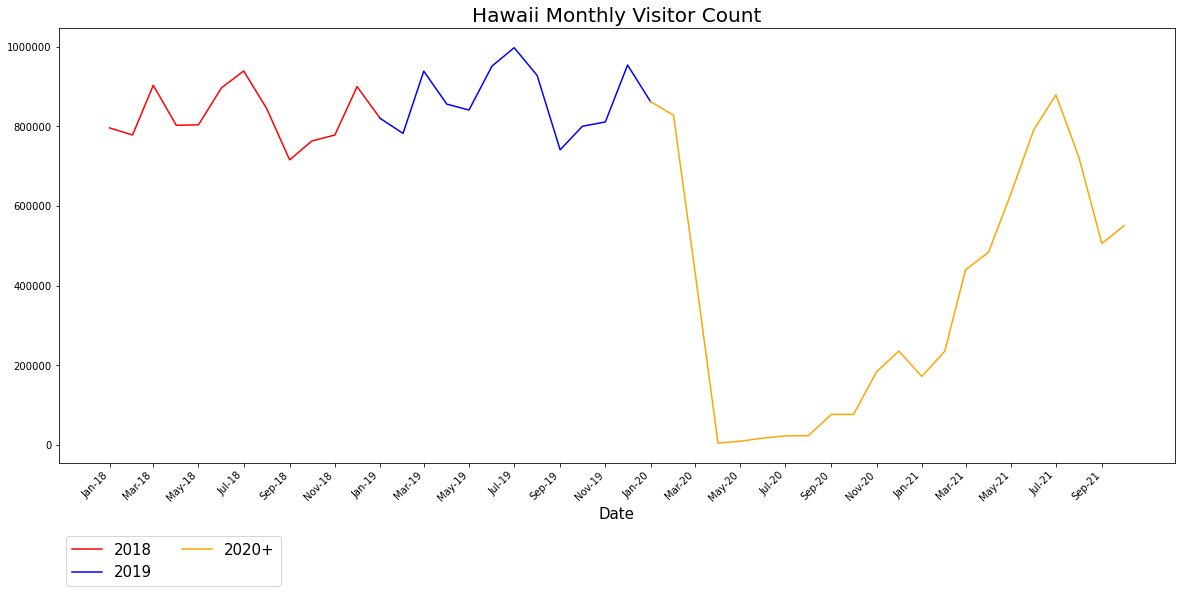

In [9]:
x = [datetime.strptime(a, "%b-%y") for a in travel_data['Time'].tolist()]
hotel_rate = travel_data['Hotel rate'].tolist()
total_flights = travel_data['Total flights'].tolist()
corrected_hotel_demand = [982.6944+ 0.0721 * total_flights[i] for i in range(len(hotel_rate))]
corrected_visitor_count = [-6.995e+04 + 691.9825 * t for t in corrected_hotel_demand]
y = travel_data['Visitor Arrival'].tolist()

fig, ax = plt.subplots(figsize=(20, 8))
                                
ax.plot(x[:13],y[:13], color = "red", label = "2018")
ax.plot(x[12:25],y[12:25], color = "blue", label = "2019")
ax.plot(x[24:],y[24:], color = "orange", label = "2020+")
plt.title('Hawaii Monthly Visitor Count', size = 20)
ax.set_xlabel('Date', size = 15)
ax.set_xticks(x[::2])
ax.set_xticklabels([d.strftime("%b-%y") for d in x[::2]], rotation=45, horizontalalignment='right')
ax.legend(prop={'size': 15}, bbox_to_anchor=(0,-0.3,1,0.2), loc="lower left", ncol = 2)
plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = 'a7_output_figures/Hawaii_Monthly_Visitor_Count.png')

plt.show()


In the next plot we will combine the visitor count with the COVID confirm cases

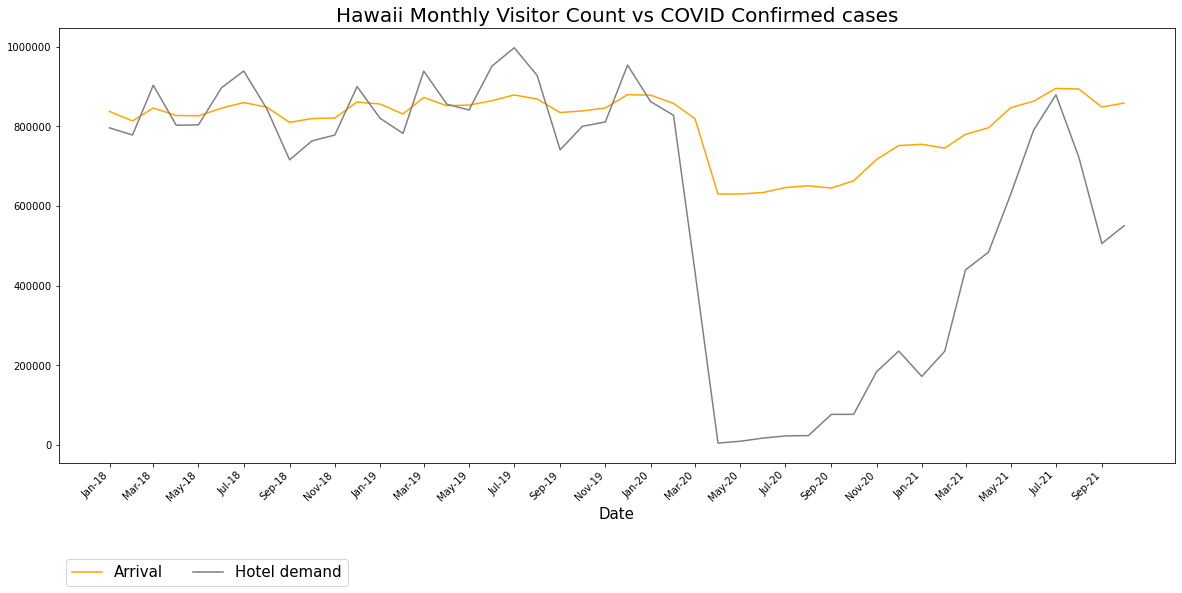

In [10]:
x = [datetime.strptime(a, "%b-%y") for a in travel_data['Time'].tolist()]
hotel_rate = travel_data['Hotel rate'].tolist()
total_flights = travel_data['Total flights'].tolist()
corrected_hotel_demand = [982.6944+ 0.0721 * total_flights[i] for i in range(len(hotel_rate))]
corrected_visitor_count = [-6.995e+04 + 691.9825 * t for t in corrected_hotel_demand]
y = travel_data['Visitor Arrival'].tolist()

fig, ax = plt.subplots(figsize=(20, 8))
                                
ax.plot(x,corrected_visitor_count, color = "orange", label = "Arrival")
ax.plot(x,y, color = "grey", label = "Hotel demand")
plt.title('Hawaii Monthly Visitor Count vs COVID Confirmed cases', size = 20)
ax.set_xlabel('Date', size = 15)
ax.set_xticks(x[::2])
ax.set_xticklabels([d.strftime("%b-%y") for d in x[::2]], rotation=45, horizontalalignment='right')
ax.legend(prop={'size': 15}, bbox_to_anchor=(0,-0.3,1,0.2), loc="lower left", ncol = 2)
plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = 'a7_output_figures/Hawaii_Monthly_Visitor_Count_vs_covid_cases.png')

plt.show()


## Tourism statistics - flights and hotels

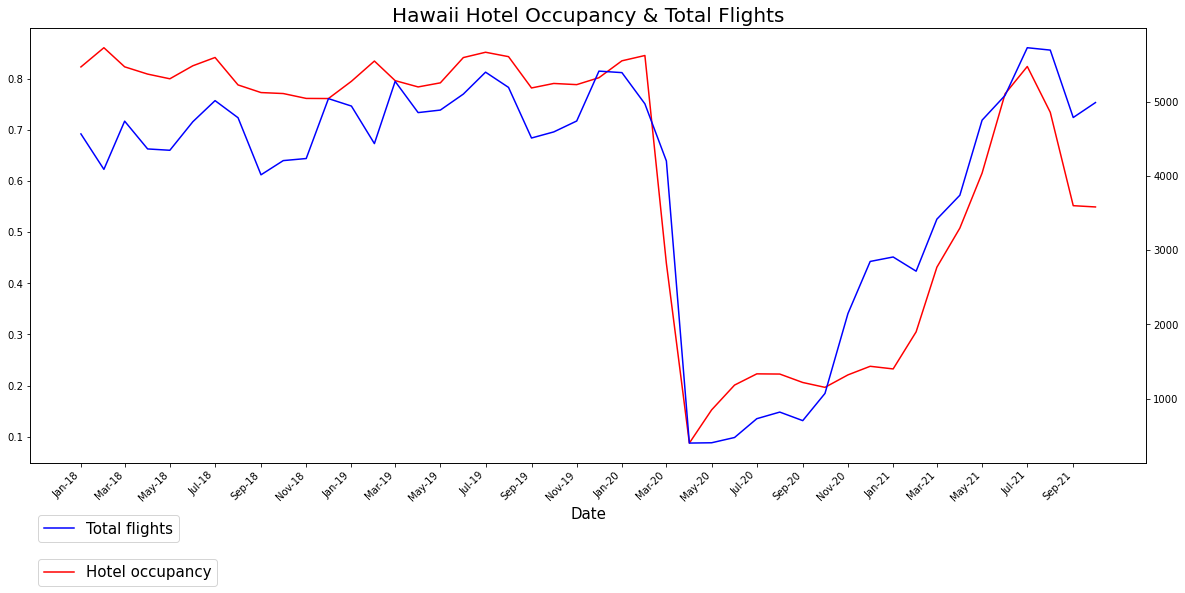

In [11]:
x = [datetime.strptime(a, "%b-%y") for a in travel_data['Time'].tolist()]
hotel_rate = travel_data['Hotel rate'].tolist()
total_flights = travel_data['Total flights'].tolist()
hotel_occupancy = travel_data['Hotel Occupancy'].tolist()
y = travel_data['Visitor Arrival'].tolist()
y = hotel_occupancy
fig, ax = plt.subplots(figsize=(20, 8))
ax2 = ax.twinx()
                                
ax.plot(x,y, color = "red", label = "Hotel occupancy")
ax2.plot(x,total_flights, color = "blue", label = "Total flights")

plt.title('Hawaii Hotel Occupancy & Total Flights', size = 20)
ax.set_xlabel('Date', size = 15)
ax.set_xticks(x[::2])
ax.set_xticklabels([d.strftime("%b-%y") for d in x[::2]], rotation=45, horizontalalignment='right')
ax.legend(prop={'size': 15}, bbox_to_anchor=(0,-0.3,1,0.2), loc="lower left", ncol = 2)
ax2.legend(prop={'size': 15}, bbox_to_anchor=(0,-0.2,1,0.2), loc="lower left", ncol = 2)

plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = 'a7_output_figures/hotel_flights.png')

plt.show()


## Predicting visitor count through linear regression
I performed linear regression on hotel demand and total visitors, and found that there is a very high correlation between hotel demand and the total visitor count both before and after the pandemic. With this, I will then use total flights to predict the hotel demand with pre-pandemic periods, since I also found high correlation in them. In this way I have a method to use pre-pandemic data to train a model using total flights information, and use this model to predict the visitor count for post-pandemic periods.


### Fitting hotel demand using hotel rate and total flights

In [12]:
hotel_demand = travel_data['Hotel Demand'].tolist()[0:26]
hotel_rate = travel_data['Hotel rate'].tolist()[0:26]
total_flights = travel_data['Total flights'].tolist()[0:26]
X = np.array([hotel_rate, total_flights]).T
y = hotel_demand

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     4.374
Date:                Tue, 14 Dec 2021   Prob (F-statistic):             0.0246
Time:                        20:04:25   Log-Likelihood:                -137.08
No. Observations:                  26   AIC:                             280.2
Df Residuals:                      23   BIC:                             283.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        991.4884    121.303      8.174      0.0

### Fitting hotel demand with flights

In [13]:
hotel_demand = travel_data['Hotel Demand'].tolist()[0:26]
hotel_rate = travel_data['Hotel rate'].tolist()[0:26]
total_flights = travel_data['Total flights'].tolist()[0:26]
X = total_flights
y = hotel_demand

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     9.019
Date:                Tue, 14 Dec 2021   Prob (F-statistic):            0.00616
Time:                        20:04:25   Log-Likelihood:                -137.13
No. Observations:                  26   AIC:                             278.3
Df Residuals:                      24   BIC:                             280.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        982.6944    114.768      8.562      0.0

### Fitting visitor arrival with hotel demand

In [14]:
arrival = travel_data['Visitor Arrival'].tolist()
hotel_demand = travel_data['Hotel Demand'].tolist()
X = hotel_demand
y = arrival

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2118.
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           7.45e-39
Time:                        20:04:25   Log-Likelihood:                -559.24
No. Observations:                  46   AIC:                             1122.
Df Residuals:                      44   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.995e+04   1.65e+04     -4.231      0.0

### Visualizing linear regression
In the following plot we will visualize the linear regression using the flight data.

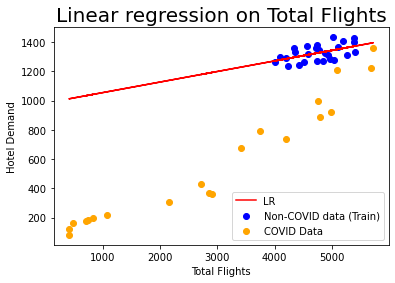

In [15]:
x = travel_data['Total flights'].tolist()
y = travel_data['Hotel Demand'].tolist()

regression = [982.6944+ 0.0721 * x[i] for i in range(len(x))]
                                                                                 
plt.scatter(x[0:26],y[0:26], color = "blue", label = "Non-COVID data (Train)")
plt.scatter(x[26:],y[26:], color = "orange", label = "COVID Data")
plt.plot(x,regression, color = "red", label = "LR")
plt.title('Linear regression on Total Flights', size = 20)
plt.ticklabel_format(axis="y", style="plain")
plt.xlabel('Total Flights')
plt.ylabel('Hotel Demand')
plt.legend(loc="lower right")
plt.savefig(fname = 'a7_output_figures/linear_regression_visualization.png')

plt.show()


## Flight corrected total visitor count
Using the linear regression models above, we generate the corrected visitor counts in the following section

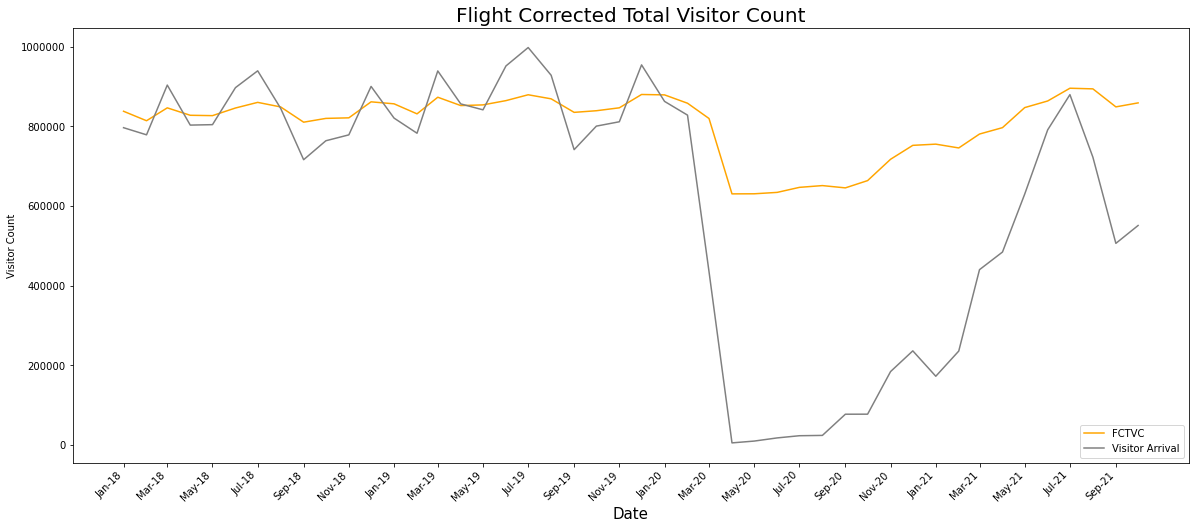

In [16]:
x = [datetime.strptime(a, "%b-%y") for a in travel_data['Time'].tolist()]
hotel_rate = travel_data['Hotel rate'].tolist()
total_flights = travel_data['Total flights'].tolist()
corrected_hotel_demand = [982.6944+ 0.0721 * total_flights[i] for i in range(len(hotel_rate))]
corrected_visitor_count = [-6.995e+04 + 691.9825 * t for t in corrected_hotel_demand]
y = travel_data['Visitor Arrival'].tolist()

fig, ax = plt.subplots(figsize=(20, 8))
                                                                                 
# plt.plot(x,daily_cases, color = "black", label = "Daily confirmed cases")
ax.plot(x,corrected_visitor_count, color = "orange", label = "FCTVC")
ax.plot(x,y, color = "grey", label = "Visitor Arrival")
ax.set_xlabel('Date', size = 15)
ax.set_ylabel("Visitor Count")
ax.set_xticks(x[::2])
ax.set_xticklabels([d.strftime("%b-%y") for d in x[::2]], rotation=45, horizontalalignment='right')
plt.title('Flight Corrected Total Visitor Count', size = 20)
plt.legend(loc="lower right")
plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = 'a7_output_figures/flight_corrected_total_visitor_count.png')

plt.show()
